In [ ]:
%load_ext autoreload
%autoreload 2
from network import *

In [ ]:
# 필요한 라이브러리 불러오기
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(y):
    encoder = OneHotEncoder(sparse=False)
    y_reshaped = y.reshape(-1, 1)
    return encoder.fit_transform(y_reshaped)

# Iris 데이터셋 불러오기
iris = load_digits()
X = iris.data
y = iris.target
y = one_hot_encode(y)
# 데이터셋을 train과 test로 분할 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 출력
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')


## 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [ ]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

In [ ]:
X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.numerical_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

In [ ]:
network.params

In [ ]:
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

## 5.7.4 오차역전파법을 사용한 학습 구현하기

### Using gradient descent

0.10299234516353514 0.1361111111111111
0.5998608211551845 0.5972222222222222
0.7397355601948504 0.7472222222222222
0.8093249826026444 0.7916666666666666
0.8392484342379958 0.8194444444444444
0.8844815588030619 0.8388888888888889
0.9025748086290883 0.8638888888888889
0.906054279749478 0.8638888888888889
0.918580375782881 0.8972222222222223
0.9387613082811412 0.9
0.9443284620737648 0.9
0.9387613082811412 0.9166666666666666
0.9526791927627001 0.9166666666666666
0.9478079331941545 0.9138888888888889
0.9610299234516354 0.9194444444444444
0.9603340292275574 0.9222222222222223
0.9693806541405706 0.925
0.965205288796103 0.9333333333333333
0.9728601252609603 0.9305555555555556
0.9749478079331941 0.9305555555555556
0.9770354906054279 0.9416666666666667
0.9756437021572721 0.9388888888888889
0.9798190675017397 0.9416666666666667
0.9798190675017397 0.9333333333333333
0.9805149617258176 0.9333333333333333
0.9798190675017397 0.9333333333333333
0.9832985386221295 0.9388888888888889
0.9846903270702854 

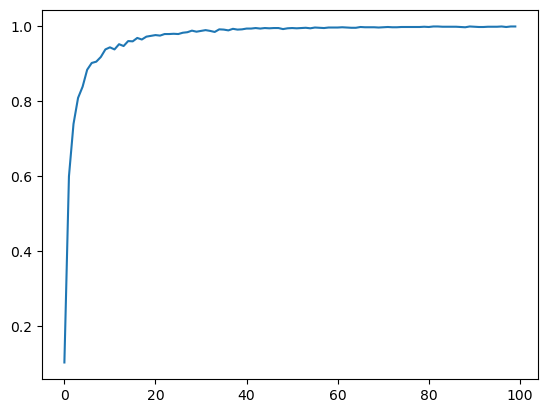

In [105]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

### Using moment

0.13430758524704245 0.15833333333333333
0.4815588030619346 0.5222222222222223
0.6367432150313153 0.6722222222222223
0.7181628392484343 0.7333333333333333
0.7794015309672929 0.8055555555555556
0.8281141266527487 0.8472222222222222
0.8622129436325678 0.8638888888888889
0.8782185107863605 0.8722222222222222
0.8983994432846207 0.9
0.9081419624217119 0.9
0.9241475295755045 0.9111111111111111
0.9248434237995825 0.9194444444444444
0.9352818371607515 0.9277777777777778
0.9345859429366736 0.9138888888888889
0.9478079331941545 0.9333333333333333
0.9491997216423104 0.9361111111111111
0.9547668754349339 0.9277777777777778
0.9631176061238692 0.9361111111111111
0.9679888656924147 0.9416666666666667
0.9631176061238692 0.9416666666666667
0.9700765483646486 0.9416666666666667
0.9728601252609603 0.95
0.97633959638135 0.95
0.9742519137091162 0.9444444444444444
0.9735560194850382 0.9555555555555556
0.9805149617258176 0.9527777777777777
0.9812108559498957 0.9416666666666667
0.9867780097425192 0.95277777777

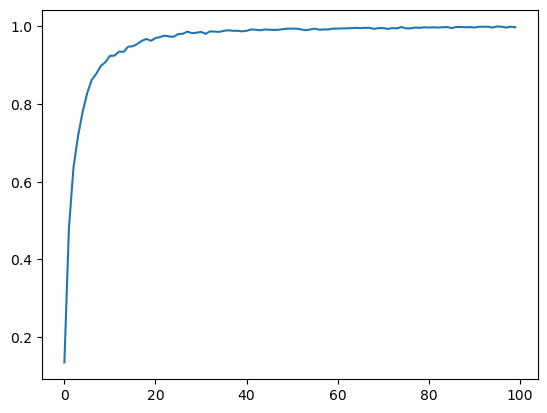

In [107]:
import copy
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)

num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.03
alpha = 0.5
moment = copy.deepcopy(network.params)
for key in list(moment.keys()):
    moment[key] *= 0

train_loss_log = []
train_acc_log = []
test_acc_log = []
grad = None
for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
         moment[key] = alpha*moment[key] - learning_rate*grad[key]
         network.params[key] += moment[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()

### Using learning rate decay

0.18997912317327767 0.2111111111111111
0.3430758524704245 0.3138888888888889
0.5594989561586639 0.5027777777777778
0.6388308977035491 0.6
0.7056367432150313 0.6722222222222223
0.7466945024356297 0.725
0.8176757132915797 0.7388888888888889
0.8427279053583855 0.7861111111111111
0.8670842032011135 0.8305555555555556
0.9032707028531664 0.8388888888888889
0.9053583855254002 0.8611111111111112
0.9199721642310369 0.8694444444444445
0.9318023660403618 0.8916666666666667
0.942936673625609 0.8944444444444445
0.9547668754349339 0.9111111111111111
0.9575504523312457 0.9083333333333333
0.9589422407794015 0.9194444444444444
0.9436325678496869 0.9194444444444444
0.9679888656924147 0.9111111111111111
0.9693806541405706 0.9416666666666667
0.9679888656924147 0.9416666666666667
0.9714683368128044 0.9444444444444444
0.9700765483646486 0.9361111111111111
0.9728601252609603 0.9527777777777777
0.9805149617258176 0.9472222222222222
0.977731384829506 0.9472222222222222
0.9770354906054279 0.9527777777777777
0.9

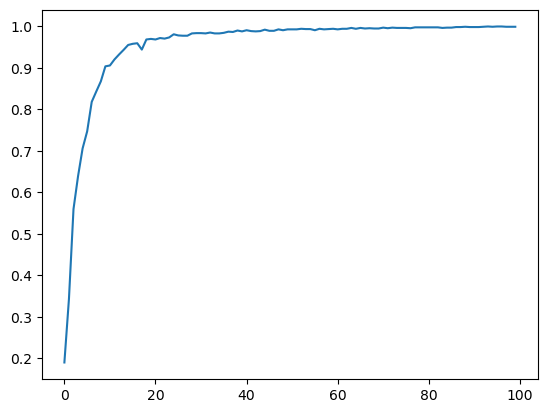

In [108]:
network = TwoLayerNetwork(X_train[0].size, 50, y_train[0].size)
num_iter = 1000
train_size = X_train.shape[0]
batch_size = 100
initial_learning_rate = 0.05
learning_rate = initial_learning_rate
learning_rate_decay = 0.99  # learning rate decay factor
train_loss_log = []
train_acc_log = []
test_acc_log = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(num_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    for key in list(network.params.keys()): # gradient descent
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(X_batch, y_batch)
    train_loss_log.append(loss)
    
    if i % iter_per_epoch == 0:
        learning_rate *= learning_rate_decay  # decay the learning rate
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_log.append(train_acc)
        test_acc_log.append(test_acc)
        print(train_acc, test_acc)
        
plt.plot(np.arange(len(train_acc_log)), np.array(train_acc_log))
plt.show()
